In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
import pandas as pd
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ilyas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import pandas as pd

# Lire le fichier
df = pd.read_csv("../data/training.1600000.processed.noemoticon.csv", encoding="latin-1")

# Prendre la moitié des lignes (les premières)
half_df = df.iloc[:len(df)//2]

print(half_df.shape)
print(half_df.head())


(799999, 6)
   0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY _TheSpecialOne_  \
0  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   scotthamilton   
1  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY        mattycus   
2  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY         ElleCTF   
3  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          Karoli   
4  0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY        joy_wolf   

  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  
0  is upset that he can't update his Facebook by ...                                                                   
1  @Kenichan I dived many times for the ball. Man...                                                                   
2    my whole body feels itchy and like its on fire                                                                    
3  @nationwideclass no, it's not behaving at all...

In [3]:
 # Garder les colonnes par position (0 = sentiment, 5 = texte)
df = df.iloc[:, [0, 5]]

# Renommer les colonnes pour plus de clarté
df.columns = ['sentiment', 'text']

# Afficher les 5 premières lignes
print(df.head())


   sentiment                                               text
0          0  is upset that he can't update his Facebook by ...
1          0  @Kenichan I dived many times for the ball. Man...
2          0    my whole body feels itchy and like its on fire 
3          0  @nationwideclass no, it's not behaving at all....
4          0                      @Kwesidei not the whole crew 


In [4]:
df.duplicated().sum()


np.int64(16309)

In [5]:
df.drop_duplicates(inplace=True)


In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1583690 entries, 0 to 1599998
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1583690 non-null  int64 
 1   text       1583690 non-null  object
dtypes: int64(1), object(1)
memory usage: 36.2+ MB


In [6]:
df.describe()


,sentiment
count,1.583690e+06
mean,2.004195e+00
std,1.999996e+00
min,0.000000e+00
25%,0.000000e+00
50%,4.000000e+00
75%,4.000000e+00
max,4.000000e+00


In [7]:
df.isna().sum()


sentiment    0
text         0
dtype: int64

In [8]:
# Mapping des sentiments
df['sentiment'] = df['sentiment'].map({0: 'negatif', 4: 'positif'})


In [9]:
df.sentiment.value_counts()


sentiment
positif    793506
negatif    790184
Name: count, dtype: int64

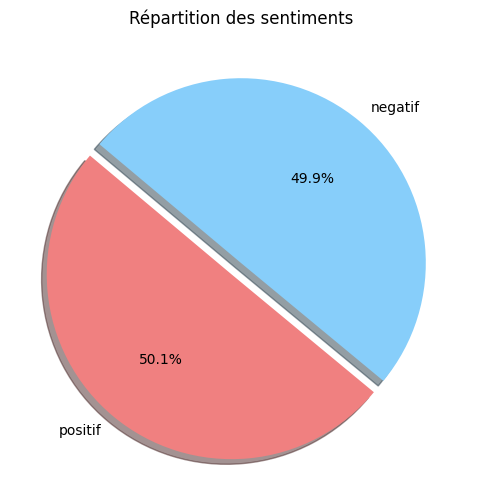

In [10]:
import matplotlib.pyplot as plt

# Si tu veux des couleurs custom, par exemple :
colors = ['lightcoral', 'lightskyblue']

# Plot pie chart
df["sentiment"].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    figsize=(8, 6),
    explode=(0.08, 0),  # un peu d'explosion sur la première part
    shadow=True,
    colors=colors,
    startangle=140  # rotation pour un meilleur rendu
)

plt.title('Répartition des sentiments')
plt.ylabel('')  # Pour enlever le label de l'axe y qui apparait par défaut
plt.show()


In [11]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['Lsentiment_encoded'] = encoder.fit_transform(df['sentiment'])


In [12]:
import re
import string
from nltk.corpus import stopwords

# Charger les stopwords anglais
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Mettre en minuscules
    text = text.lower()
    
    # Supprimer les URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    
    # Supprimer les mentions (@user)
    text = re.sub(r'@\w+', '', text)
    
    # Supprimer les hashtags (#hashtag)
    text = re.sub(r'#\w+', '', text)
    
    # Supprimer la ponctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Supprimer les chiffres
    text = re.sub(r'\d+', '', text)
    
    # Supprimer les espaces multiples
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Supprimer les stopwords anglais
    words = text.split()
    words = [word for word in words if word not in stop_words]
    
    return ' '.join(words)


In [13]:
def tokenize_and_limit(texts, max_vocab=10000, max_len=100):
    """
    texts : liste ou série de textes nettoyés
    max_vocab : nombre max de mots dans le vocabulaire (les plus fréquents)
    max_len : longueur max des séquences (padding/troncature)
    
    Retourne : sequences encodées et le tokenizer entraîné
    """
    
    # Créer le tokenizer
    tokenizer = Tokenizer(num_words=max_vocab, oov_token="<OOV>")
    
    # Entraîner le tokenizer sur les textes
    tokenizer.fit_on_texts(texts)
    
    # Convertir les textes en séquences d'entiers
    sequences = tokenizer.texts_to_sequences(texts)
    
    # Limiter/tronquer les séquences à max_len (ajoute du padding si trop court)
    padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    
    return padded, tokenizer


In [14]:
# 1. Nettoyer le texte
df['clean_text'] = df['text'].apply(preprocess_text)

# 2. Tokeniser et limiter la longueur
padded_sequences, tokenizer = tokenize_and_limit(df['clean_text'], max_vocab=10000, max_len=100)

# Vérifier la forme des séquences
print(padded_sequences.shape)


(1583690, 100)


In [15]:
print(df['clean_text'].head())


0    upset cant update facebook texting might cry r...
1    dived many times ball managed save rest go bounds
2                     whole body feels itchy like fire
3                             behaving im mad cant see
4                                           whole crew
Name: clean_text, dtype: object


In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# 1. Encodage one-hot des labels (tu as déjà fait)
y = pd.get_dummies(df['sentiment'])

# 2. Features (texte nettoyé)
X = df['clean_text']

# 3. Split 80% train_val + 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y)

# 4. Split 75% train + 25% val (=> 60% train, 20% val, 20% test)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=1, stratify=y_train_val)

# 5. Tokenizer + padding sur les splits

max_vocab = 10000
max_len = 100

# Entraîner le tokenizer uniquement sur les données d'entraînement
tokenizer = Tokenizer(num_words=max_vocab, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convertir textes en séquences et padder
X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len, padding='post', truncating='post')
X_val_pad = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len, padding='post', truncating='post')

# Vérifier les tailles
print(f"Train padded shape     : {X_train_pad.shape}")
print(f"Validation padded shape: {X_val_pad.shape}")
print(f"Test padded shape      : {X_test_pad.shape}")


Train padded shape     : (950214, 100)
Validation padded shape: (316738, 100)
Test padded shape      : (316738, 100)


In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- Paramètres ---
max_vocab = 10000     # taille maximale du vocabulaire (à adapter selon ton tokenizer)
max_len = 100         # longueur maximale des séquences (après padding)
embedding_size = 32
epochs = 20
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

# --- Optimiseur ---
sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate)

# --- Création du modèle ---
model = Sequential([
    Embedding(input_dim=max_vocab, output_dim=embedding_size, input_length=max_len),
    Conv1D(32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(32)),
    Dropout(0.4),
    Dense(2, activation='softmax')  # 2 classes : positif / négatif
])

# --- Compilation ---
model.compile(optimizer=sgd,
              loss=CategoricalCrossentropy(),
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

model.build(input_shape=(None, max_len))
model.summary()

# --- Callbacks ---
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# ✅ Format recommandé (évite le warning)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)


c:\Users\ilyas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
c:\Users\ilyas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 100, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 339,874 (1.30 MB)

 Trainable params: 339,874 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=epochs,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/20
29695/29695 ━━━━━━━━━━━━━━━━━━━━ 588s 20ms/step - accuracy: 0.7299 - loss: 0.5244 - precision: 0.7299 - recall: 0.7299 - val_accuracy: 0.7837 - val_loss: 0.4561 - val_precision: 0.7837 - val_recall: 0.7837
Epoch 2/20
29695/29695 ━━━━━━━━━━━━━━━━━━━━ 854s 28ms/step - accuracy: 0.7861 - loss: 0.4545 - precision: 0.7861 - recall: 0.7861 - val_accuracy: 0.7832 - val_loss: 0.4642 - val_precision: 0.7832 - val_recall: 0.7832
Epoch 3/20
29695/29695 ━━━━━━━━━━━━━━━━━━━━ 1693s 57ms/step - accuracy: 0.7942 - loss: 0.4406 - precision: 0.7942 - recall: 0.7942 - val_accuracy: 0.7894 - val_loss: 0.4514 - val_precision: 0.7894 - val_recall: 0.7894
Epoch 4/20
29695/29695 ━━━━━━━━━━━━━━━━━━━━ 1068s 36ms/step - accuracy: 0.8002 - loss: 0.4313 - precision: 0.8002 - recall: 0.8002 - val_accuracy: 0.7767 - val_loss: 0.4667 - val_precision: 0.7767 - val_recall: 0.7767
Epoch 5/20
29695/29695 ━━━━━━━━━━━━━━━━━━━━ 1029s 35ms/step - accuracy: 0.8046 - loss: 0.4236 - precision: 0.8046 - recall: 0.8046

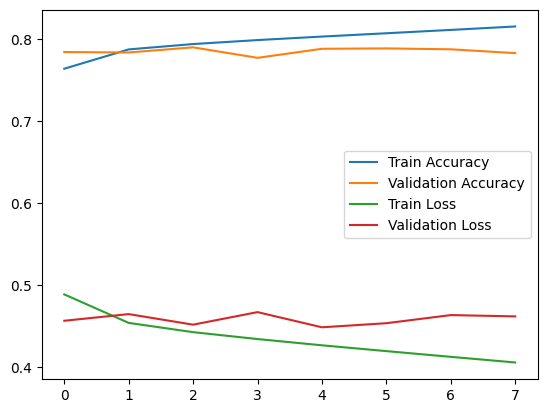

In [22]:
import matplotlib.pyplot as plt

# Précision et perte (loss) pendant l'entraînement
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [25]:
from tensorflow.keras.models import load_model

# Charger le modèle enregistré
best_model = load_model('best_model.keras')

# Ensuite évaluer
results = best_model.evaluate(X_test_pad, y_test, batch_size=32)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")
print(f"Test Precision: {results[2]:.4f}")
print(f"Test Recall: {results[3]:.4f}")


9899/9899 ━━━━━━━━━━━━━━━━━━━━ 95s 9ms/step - accuracy: 0.7885 - loss: 0.4483 - precision: 0.7885 - recall: 0.7885
Test Loss: 0.4476
Test Accuracy: 0.7885
Test Precision: 0.7885
Test Recall: 0.7885
